# Analyse GPS data

First part of notebook does analysis for single GPS day, as an example.

Second part runs through multiple days.

For each day of data:

1. Keep only clocks with no missing data points
2. Form the weighted average of all clocks into a single data stream: $\delta\omega/\omega$
3. Calculate amplitude spectrum from weighted average frequencies for given day
4. Repeat above for multiple days: have 1 spectrum for each day
5. Constraint and condifence given by mean and standard error in ensemble of spectrums


Each data stream has contribution from: 
  - unique satellite (Rb) clock noise, $n_i$
  - common (ground-based) reference clock noise, $r$
  - common dark matter signal (may be zero), $s$
  
Data stream from $i$ th clock, $c_i$

$$
  c_i = n_i + r + s
$$

The weighted average data stream, $d$, is thus

$$
    d = \frac{\sum_i \sigma_i^{-2}(n_i + r + s)}{\sum_i \sigma_i^{-2}} \\
    ~\\
      = \frac{\sum_i \sigma_i^{-2}\,n_i}{\sum_i \sigma_i^{-2}}  + r + s
$$

In [1]:
import AnalyseGPS as gps
import allantools
import scipy.stats as stats
import numpy as np
from matplotlib import pyplot as plt

## Single day, as example

### Frequncy data
Clock data is GPS (Rb) clock, referenced to ground-based H-maser

* Block II, IIA satellites: very old (none currently in use)
* Block IIR - launched from 1997. Still some in operation. Very noisy
* Block IIF - Launched between 2010 and 2016 - good clocks
* Block III - Launched between 2018 and 2023 - good clocks

In [2]:
# Current satellite configuration:
# Technically changes over time, but stable for considered period
# Also: not required for analysis, just for interest
satellites = np.genfromtxt("current_satellites.txt", dtype=str)
Block = {a: c for a, _, c, _ in satellites}

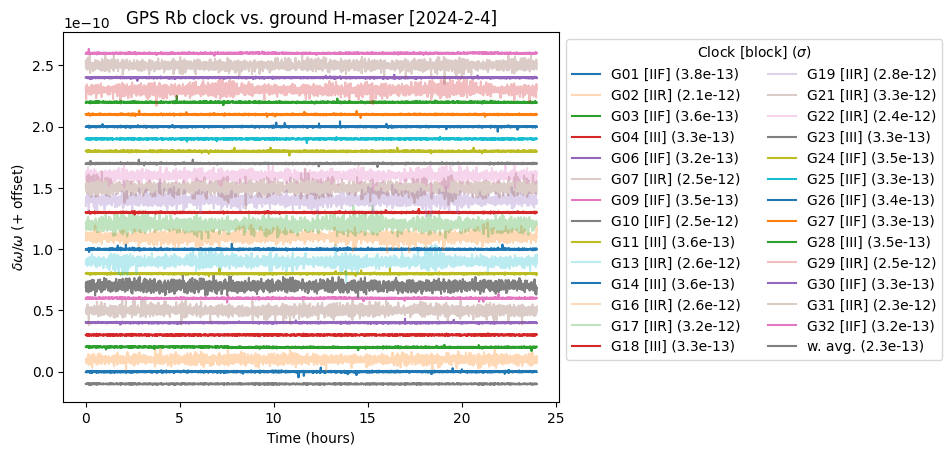

In [3]:
week, day = 2300, 0

# Download the data, if not already downloaded
fname = gps.download_data(week, day)

# Parse the clock data
data, date = gps.get_data(fname)

# Extract frequencies for "good" clocks (no missing data)
good_clocks, dws = gps.get_good_clocks(data)

dw_avg = gps.form_weighted_average(dws, good_clocks)
dw_avg_2 = gps.form_weighted_average(dws, good_clocks, 1e-12)

# Time (in hours), only for plotting:
time = np.linspace(0, 24, gps.num_data_points)

offset = 1e-11
for index, clock in enumerate(good_clocks):
    sigma = np.std(dws[index])
    mean = np.mean(dws[index])
    block = Block[clock]
    # Change opacity depending on old/new satellite (IIR is old)
    opacity = 0.3 if block == "IIR" else 1.0
    plt.plot(
        time,
        dws[index] - mean + index * offset,
        label=f"{clock} [{block}] ({sigma:.1e})",
        alpha=opacity,
    )

sigma = np.std(dw_avg)
plt.plot(time, dw_avg - offset, label=f"w. avg. ({sigma:.1e})")

plt.title(f"GPS Rb clock vs. ground H-maser [{date}]")
plt.xlabel("Time (hours)")
plt.ylabel("$\\delta\\omega/\\omega$ (+ offset)")
plt.legend(ncols=2, bbox_to_anchor=(1, 1), title="Clock [block] ($\\sigma$)")
plt.show()

* "Faint" lines are older GPS IIR satellite clocks
* G10 is a IIF clock, but seems to perform poorly, like a IIR clock

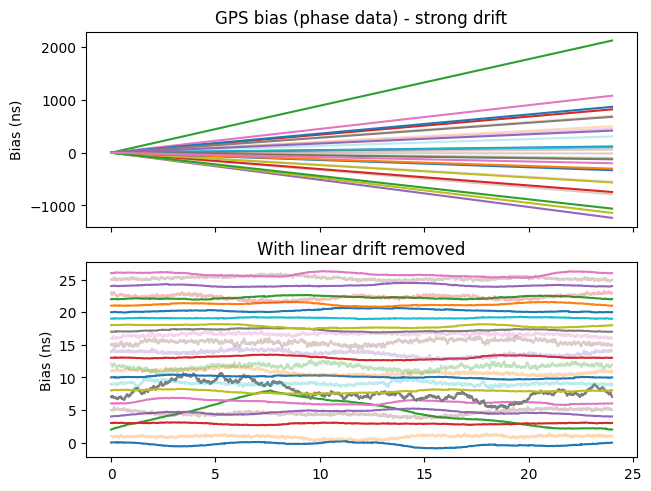

In [4]:
fig, [ax1, ax2] = plt.subplots(2, 1, layout="constrained", sharex=True)

for index, clock in enumerate(good_clocks):
    phase = data[data["PRN"] == clock]["Bias"].to_numpy()[:-1]
    # Begin data on zero
    phase -= phase[0]

    block = Block[clock]
    opacity = 0.3 if block == "IIR" else 1.0

    # Plot raw bias data (shifted to start at 0)
    ax1.plot(time, phase * 1e9, alpha=opacity)

    # Sabtract off a linear drift (drift in phase, not freq.)
    m = phase[-1] / 24.0
    phase -= time * m
    ax2.plot(time, phase * 1e9 + index, alpha=opacity)


ax1.set_title("GPS bias (phase data) - strong drift")
ax1.set_ylabel("Bias (ns)")
ax2.set_title("With linear drift removed")
ax2.set_ylabel("Bias (ns)")
plt.show()

## Let's look closer at G03 - which does something weird
* Weird "step" for clock on this day 
* At least we know they don't remove outliers from the data!

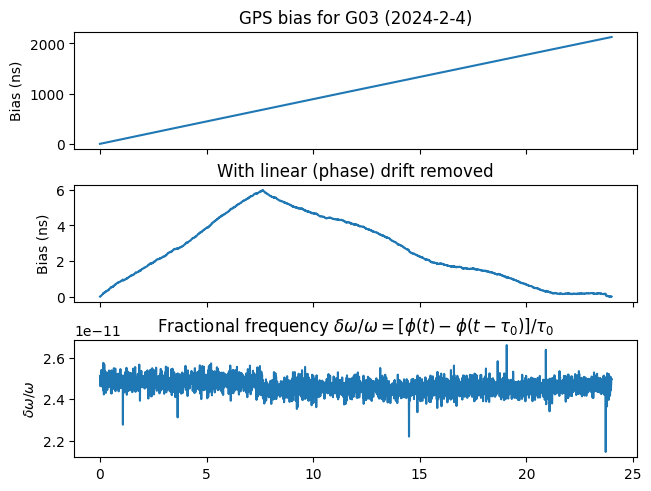

In [5]:
fig, [ax1, ax2, ax3] = plt.subplots(3, 1, layout="constrained", sharex=True)

for index, clock in enumerate(good_clocks):
    if clock != "G03":
        continue
    phase = data[data["PRN"] == clock]["Bias"].to_numpy()[:-1]
    # Begin data on zero
    phase -= phase[0]

    # Plot raw phase
    ax1.plot(time, phase * 1e9, label=clock, alpha=opacity)

    # Subtract off a linear drift (drift in phase, not freq.)
    m = phase[-1] / 24.0
    phase -= time * m
    ax2.plot(time, phase * 1e9, label=clock, alpha=opacity)

    # Plot frequency deviations:
    ax3.plot(time, dws[index])


ax1.set_title(f"GPS bias for G03 ({date})")
ax1.set_ylabel("Bias (ns)")
ax2.set_title(f"With linear (phase) drift removed")
ax2.set_ylabel("Bias (ns)")
ax3.set_title(
    "Fractional frequency $\\delta\\omega/\\omega = [\\phi(t)-\\phi(t-\\tau_0)]/\\tau_0$"
)
ax3.set_ylabel("$\\delta\\omega/\\omega$")
plt.show()

### Allan deviations
* Can see clear separation between block III/IIF and older block IIR satellites
* Solid lines is both are modern (III or IIF) satellites, dashed is 1 is, dotted means neither

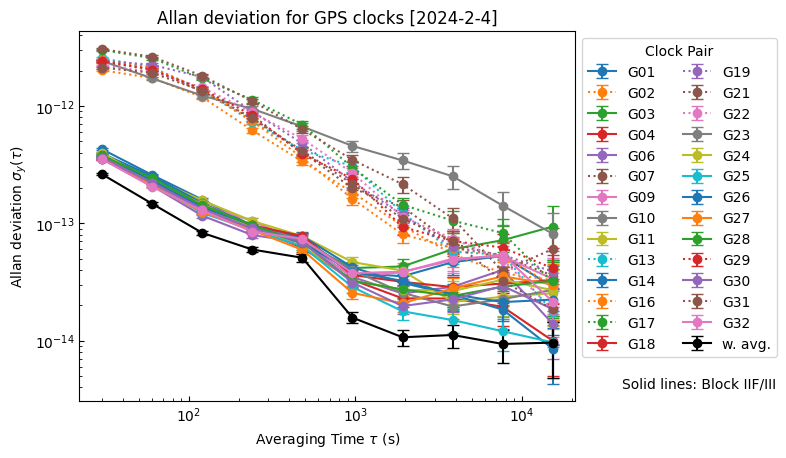

In [6]:
for index, clock in enumerate(good_clocks):

    block = Block[clock]
    modern = lambda a: a == "III" or a == "IIF"
    color = "green" if modern(block) else "red"
    style = "solid" if modern(block) else "dotted"

    # ADEV of each clock
    dw = dws[index] - np.mean(dws[index])
    (t1, ad, ade, adn) = allantools.adev(dw, rate=1.0 / gps.tau0, data_type="freq")
    plt.errorbar(t1, ad, yerr=ade, marker="o", ls=style, capsize=4, label=clock)

# ADEV of the weighted average
(t1, ad, ade, adn) = allantools.adev(dw_avg, rate=1.0 / gps.tau0, data_type="freq")
plt.errorbar(t1, ad, yerr=ade, marker="o", color="k", capsize=4, label="w. avg.")

plt.tick_params(direction="in", which="both")
plt.yscale("log")
plt.xscale("log")
plt.xlabel("Averaging Time $\\tau$ (s)")
plt.ylabel("Allan deviation $\\sigma_y(\\tau)$")
plt.title(f"Allan deviation for GPS clocks [{date}]")
plt.legend(ncols=2, bbox_to_anchor=(1, 1), title="Clock Pair")
plt.text(4e4, 4e-15, "Solid lines: Block IIF/III")
plt.show()

### And finally, amplitude spectrum:

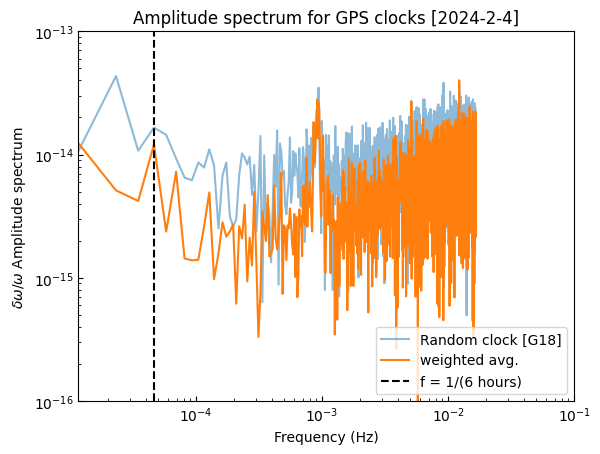

In [7]:
# Amplitude from a single random pair of clocks (for comparison):
i_a = np.random.randint(0, len(good_clocks))
dw_a = dws[i_a] - np.mean(dws[i_a])
clock_a = good_clocks[i_a]
amp_single = gps.amplitude_spectrum(dw_a)
plt.plot(
    gps.freq,
    amp_single,
    label=f"Random clock [{clock_a}]",
    alpha=0.5,
)

# Amplitude of weigthed average:
amp_avg = gps.amplitude_spectrum(dw_avg)
plt.plot(gps.freq, amp_avg, label="weighted avg.")

fmin = 1.0 / (len(dw_avg) * gps.tau0)

plt.title(f"Amplitude spectrum for GPS clocks [{date}]")
plt.xlabel("Frequency (Hz)")
plt.ylabel("$\\delta\\omega/\\omega$ Amplitude spectrum")
plt.xlim(fmin, 0.1)
plt.ylim(1e-16, 1e-13)
plt.xscale("log")
plt.yscale("log")
plt.tick_params(direction="in", which="both")

plt.axvline(1 / (6 * 60 * 60), c="k", ls="dashed", label="f = 1/(6 hours)")

plt.legend(loc="lower right")
plt.show()

### Multiple days

In theory, we can use more than 1 day of data to push to lower frequencies.
However, freely provided clock solutions are re-processed each day, meaning phase info from 1 day to next is lost. Probably, frequencies are still fine, but this processing presumably introduces some artifacts, which means data may not be useful.

In [8]:
fname2 = gps.download_data(week, day + 1)
data2, date2 = gps.get_data(fname2)
time2 = time + time[-1]

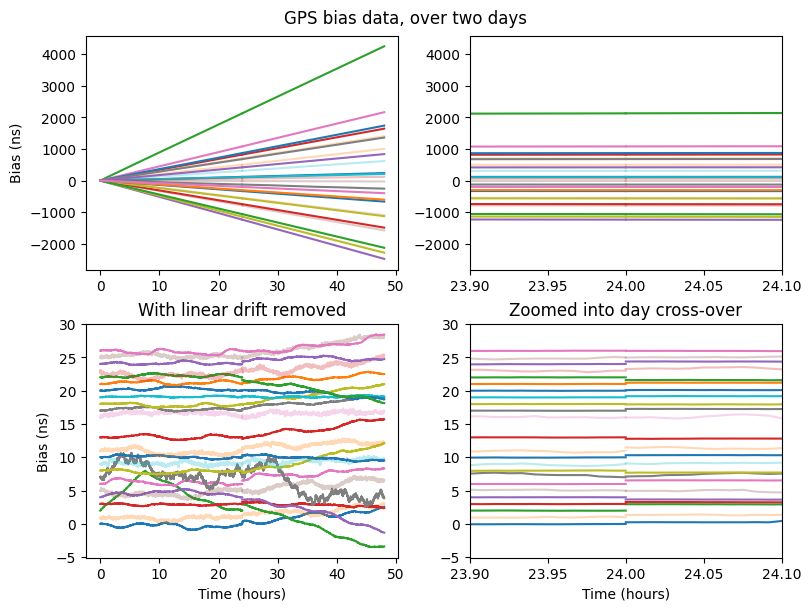

In [9]:
fig, [[ax1, ax3], [ax2, ax4]] = plt.subplots(
    2, 2, layout="constrained", sharex=False, sharey=False, figsize=(8, 6)
)
for index, clock in enumerate(good_clocks):
    phase1 = data[data["PRN"] == clock]["Bias"].to_numpy()[:-1]
    phase2 = data2[data2["PRN"] == clock]["Bias"].to_numpy()[:-1]

    if len(phase2) != 2880:
        continue

    # Begin data on zero
    begin = phase1[0]
    phase1 -= begin
    phase2 -= begin

    block = Block[clock]
    opacity = 0.3 if block == "IIR" else 1.0

    # Plot raw bias data (shifted to start at 0)
    ax1.plot(time, phase1 * 1e9, alpha=opacity, c=f"C{index}")
    ax1.plot(time2, phase2 * 1e9, alpha=opacity, c=f"C{index}")
    ax3.plot(time, phase1 * 1e9, alpha=opacity, c=f"C{index}")
    ax3.plot(time2, phase2 * 1e9, alpha=opacity, c=f"C{index}")

    # Sabtract off a linear drift (drift in phase, not freq.)
    m = phase1[-1] / 24.0
    phase1 -= time * m
    phase2 -= time2 * m
    ax2.plot(time, phase1 * 1e9 + index, alpha=opacity, c=f"C{index}")
    ax2.plot(time2, phase2 * 1e9 + index, alpha=opacity, c=f"C{index}")
    ax4.plot(time, phase1 * 1e9 + index, alpha=opacity, c=f"C{index}")
    ax4.plot(time2, phase2 * 1e9 + index, alpha=opacity, c=f"C{index}")


plt.suptitle("GPS bias data, over two days")
ax1.set_ylabel("Bias (ns)")
ax2.set_title("With linear drift removed")
ax4.set_title("Zoomed into day cross-over")
ax2.set_ylabel("Bias (ns)")
ax3.set_xlim(23.9, 24.1)
ax4.set_xlim(23.9, 24.1)
ax2.set_xlabel("Time (hours)")
ax4.set_xlabel("Time (hours)")
plt.show()

-------------------
## Part II: Full analysis

* Loop over many days of data
* Calculate spectrum for each day (from weighted average of clock pairs)
* From the set of spectra (1 for each day): get average and standard deviation (for 95% C.L.)
* Write each spectrums to files (1 file per week) - each file contains 7 spectra
    * Simply to avoid re-doing download/parsing
    * Will not re-calculate spectra for a week that's already saved

Note: rather slow: takes time to download the data, and also takes time to read in the large (~6 MB) files

In [10]:
from os import path, mkdir

save_path = "gps-spectrums-single"
if not path.exists(save_path):
    mkdir(save_path)

# Run for ~30+ weeks [2313 is latest week]
initial_week = 2280
final_week = 2313

for week in range(initial_week, final_week + 1):
    # Download and parse data, if not done already
    out_filename = f"{save_path}/gps-{week}.csv"
    if not path.isfile(out_filename):
        week_amps = []
        print(week, end=": ")
        for day in range(7):
            print(day, end=", ")
            amp, date = gps.calculate_GPS_spectrum_single(week, day)
            if not len(amp) == 0:
                week_amps.append(amp)
        # Note: this saves each amplitude as a ROW, each frequency as a column
        # don't need full precision
        np.savetxt(f"{save_path}/gps-{week}.csv", week_amps, fmt="%.6e")
        print(f": -> {out_filename}")
    else:
        print(f"Already have: {out_filename}")

Already have: gps-spectrums-single/gps-2280.csv
Already have: gps-spectrums-single/gps-2281.csv
Already have: gps-spectrums-single/gps-2282.csv
Already have: gps-spectrums-single/gps-2283.csv
Already have: gps-spectrums-single/gps-2284.csv
Already have: gps-spectrums-single/gps-2285.csv
Already have: gps-spectrums-single/gps-2286.csv
Already have: gps-spectrums-single/gps-2287.csv
Already have: gps-spectrums-single/gps-2288.csv
Already have: gps-spectrums-single/gps-2289.csv
Already have: gps-spectrums-single/gps-2290.csv
Already have: gps-spectrums-single/gps-2291.csv
Already have: gps-spectrums-single/gps-2292.csv
Already have: gps-spectrums-single/gps-2293.csv
Already have: gps-spectrums-single/gps-2294.csv
Already have: gps-spectrums-single/gps-2295.csv
Already have: gps-spectrums-single/gps-2296.csv
Already have: gps-spectrums-single/gps-2297.csv
Already have: gps-spectrums-single/gps-2298.csv
Already have: gps-spectrums-single/gps-2299.csv
Already have: gps-spectrums-single/gps-2

### Read in pre-computed specta

* Average all the spectra 

In [11]:
import glob

pre_computed_files = glob.glob(f"{save_path}/gps-*.csv")

# If already calculated, read in from text
amps = []

# Don't include 0 or negative frequencies
i0_gps = np.where(gps.freq >= fmin)[0][0]
f_gps = gps.freq[i0_gps:]

for file in pre_computed_files:
    week_amps = np.genfromtxt(file)
    for t_amp in week_amps:
        amps.append(t_amp[i0_gps:])
amps = np.array(amps)

amp = np.mean(amps, axis=0)
std_dev = np.std(amps, axis=0)
std_error = std_dev / np.sqrt(len(amps))

### Plot spectrum
* For confidence level, we use the spread of spectra, since we have 1 spectrum for each day

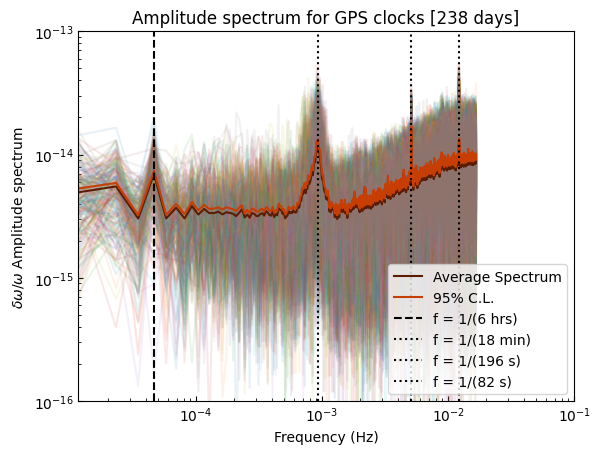

In [12]:
for t_amp in amps:
    plt.plot(f_gps, t_amp, alpha=0.1)

plt.plot(f_gps, amp, label="Average Spectrum", c="#5c1c01")
plt.plot(f_gps, amp + 2.0 * std_error, label="95% C.L.", c="#c73e04")


plt.axvline(1 / (6 * 60 * 60), c="k", ls="dashed", label="f = 1/(6 hrs)")
plt.axvline(1.0 / (18.0 * 60), c="k", ls="dotted", label="f = 1/(18 min)")

plt.axvline(1.0 / (196.0), c="k", ls="dotted", label="f = 1/(196 s)")
plt.axvline(1.0 / (82.0), c="k", ls="dotted", label="f = 1/(82 s)")

plt.title(f"Amplitude spectrum for GPS clocks [{len(amps)} days]")
plt.legend(loc="lower right")
plt.xlabel("Frequency (Hz)")
plt.ylabel("$\\delta\\omega/\\omega$ Amplitude spectrum")
plt.xlim(fmin, 0.1)
plt.ylim(1e-16, 1e-13)
plt.xscale("log")
plt.yscale("log")
plt.tick_params(direction="in", which="both")

plt.show()

## Histgram of noise of the amplitude spectrum

* noise of the amplitude spectrum is clearly not white
* However, noise of the _log_ of the amplitude spectrum is essentially white

Plot: each histogram is for a different frequency, just offset on the plot

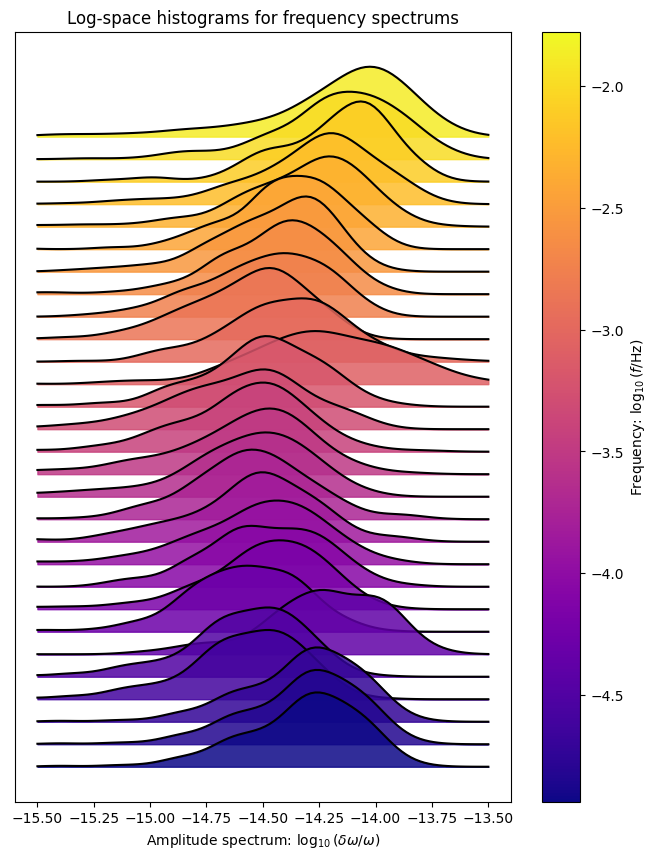

In [13]:
import matplotlib.cm as cm
from matplotlib.colors import Normalize

fig, ax1 = plt.subplots(figsize=(8, 10))

log_freq = np.log10(f_gps)
min_logf, max_logf = np.min(log_freq), np.max(log_freq)
# frequency range for plotting histogram
x_freq = np.linspace(-15.5, -13.5, 100)

# Normalise the colour bar
normalizer = Normalize(min_logf, max_logf)
im = cm.ScalarMappable(norm=normalizer, cmap="plasma")
cm = im.get_cmap()
fig.colorbar(im, ax=ax1, label="Frequency: $\\log_{10}(f/{\\rm Hz})$")

# Plot the histogram for each frequency bin:
offset = 0.5
for count, log_f in enumerate(np.linspace(min_logf, max_logf, 30)):

    # find set of amplitude spectrums corresponding to this frequency:
    jlist = np.where(f_gps >= 10.0**log_f)[0]
    if len(jlist) == 0:
        break
    j = jlist[0]
    data = np.log10(amps[:, j])

    # Find histogram (kde) of this data:
    kde = stats.gaussian_kde(data)
    t_kde = kde(x_freq)

    # set color 'float' for colour map (range 0 to 1)
    color_f = (log_f - min_logf) / (max_logf - min_logf)
    ax1.fill_between(
        x_freq,
        t_kde + count * offset,
        y2=count * offset,
        zorder=-count,
        alpha=0.85,
        color=cm(color_f),
    )
    ax1.plot(x_freq, t_kde + count * offset, zorder=-count, alpha=1.0, color="k")

plt.xlabel("Amplitude spectrum: $\\log_{10}(\\delta\\omega/\\omega)$")
plt.title("Log-space histograms for frequency spectrums")
plt.yticks([])
plt.show()

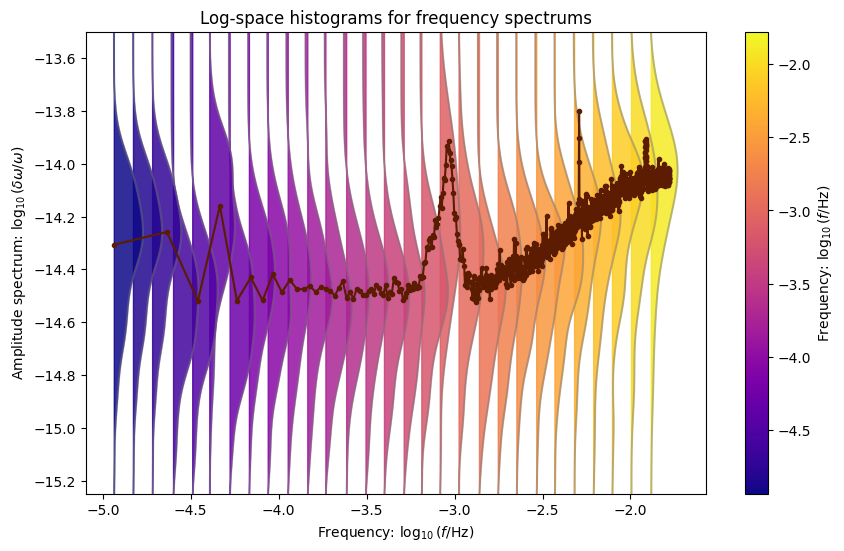

In [14]:
fig, ax1 = plt.subplots(figsize=(10, 6))


x_freq = np.linspace(-15.25, -13.5, 100)
fig.colorbar(im, ax=ax1, label="Frequency: $\\log_{10}(f/{\\rm Hz})$")
y_scale = 0.1
for count, log_f in enumerate(np.linspace(min_logf, max_logf, 30)):

    # find set of amplitude spectrums corresponding to this frequency:
    jlist = np.where(f_gps >= 10.0**log_f)[0]
    if len(jlist) == 0:
        break
    j = jlist[0]
    data = np.log10(amps[:, j])

    # Find histogram (kde) of this data:
    kde = stats.gaussian_kde(data)
    t_kde = kde(x_freq)

    # set color 'float' for colour map (range 0 to 1)
    color_f = (log_f - min_logf) / (max_logf - min_logf)
    ax1.fill_between(
        t_kde * y_scale + log_f,
        x_freq,
        zorder=-count,
        alpha=0.85,
        color=cm(color_f),
    )
    ax1.plot(t_kde * y_scale + log_f, x_freq, zorder=-count, alpha=0.5, color="grey")

plt.plot(np.log10(f_gps), np.log10(amp), ".-", c="#5c1c01")

plt.ylim(x_freq[0], x_freq[-1])
plt.ylabel("Amplitude spectrum: $\\log_{10}(\\delta\\omega/\\omega)$")
plt.xlabel("Frequency: $\\log_{10}(f/{\\rm Hz})$")
plt.title("Log-space histograms for frequency spectrums")
plt.show()

### Use boot-strap method to determine the 95% confidence levels for amplitude spectrum

* Three methods all give same results

1. Calculate mean, and standard error in mean, just assuming Normal distributed
2. Calculate error in mean from bootstrapping, 95% C.L. is ~2x this
3. Calculate 95% confidence interval directly from bootsrapping

Also: exactly the same whether I work in actual values or log values
(Essentially just a test that no issue due to floating point errors)

In [15]:
from scipy.stats import bootstrap

rng = np.random.default_rng()

# Find confidence interval on amplitude for each frequency
error = []
clupper = []
cllower = []
for j in range(len(f_gps)):
    data = (amps[:, j],)
    res = bootstrap(data, np.mean, confidence_level=0.95, n_resamples=1000)
    error.append(res.standard_error)
    clupper.append(res.confidence_interval.high)
    cllower.append(res.confidence_interval.low)
error = np.array(error)
cl95 = np.array(clupper)
cl95_lower = np.array(cllower)

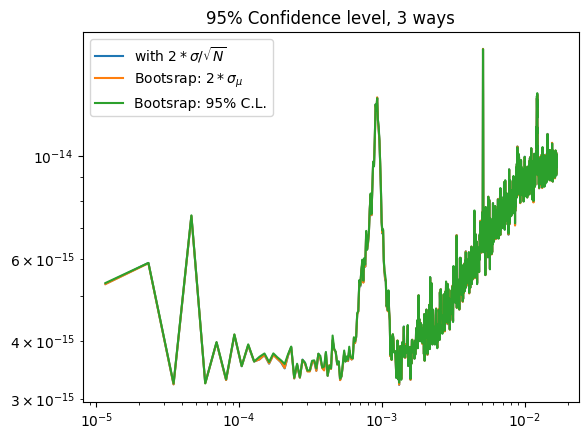

In [16]:
error1 = np.std(amps, axis=0) / np.sqrt(len(amps))

plt.loglog(f_gps, amp + 2 * error1, label="with $2*\\sigma/\\sqrt{N}$")
plt.loglog(f_gps, amp + 2 * error, label="Bootsrap: $2*\\sigma_{\\mu}$")
plt.loglog(f_gps, cl95, label="Bootsrap: 95% C.L.")

plt.title("95% Confidence level, 3 ways")
plt.legend()
plt.show()

### Investigate several big peaks a little closer
- One (~ 6hours) is probably due to orbital period (which is 12 hours)

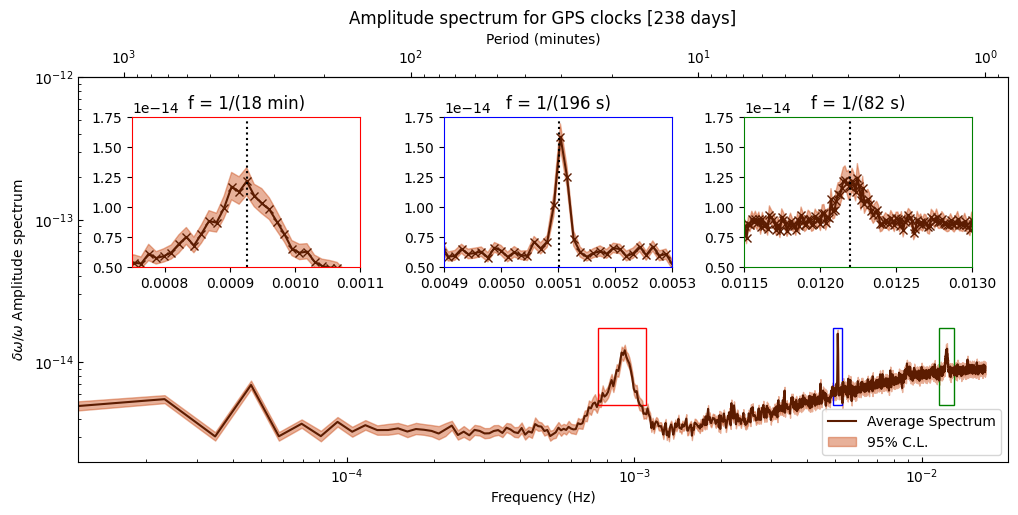

In [17]:
fig, ax1 = plt.subplots(figsize=(12, 5))
plt.plot(f_gps, amp, label="Average Spectrum", c="#5c1c01")
plt.fill_between(f_gps, cl95, cl95_lower, color="#c73e04", alpha=0.4, label="95% C.L.")

plt.title(f"Amplitude spectrum for GPS clocks [{len(amps)} days]")
plt.legend(loc="lower right")
plt.xlabel("Frequency (Hz)")
plt.ylabel("$\\delta\\omega/\\omega$ Amplitude spectrum")
plt.xlim(fmin, 2e-2)
plt.ylim(2e-15, 1e-12)
plt.xscale("log")
plt.yscale("log")
plt.tick_params(direction="in", which="both")


# For secondary axis: Period (in minutes)
T_to_f = lambda T: 1.0 / (T * 60.0)
f_to_T = lambda f: 1.0 / (f + 1e-12) / 60.0
secax = ax1.secondary_xaxis("top", functions=(T_to_f, f_to_T))
secax.set_xlabel("Period (minutes)")

# Define area to zoom in on
x1, x2 = 0.75e-3, 1.1e-3
dx = x2 - x1
y1, y2 = 0.5e-14, 1.75e-14
dy = y2 - y1
# Draw rectangle for zoom area:
ax1.add_patch(plt.Rectangle((x1, y1), dx, dy, ls="-", fc="None", ec="red"))
ax2 = fig.add_axes([0.17, 0.5, 0.19, 0.3])
plt.setp(ax2.spines.values(), ls="-", color="red")
ax2.plot(f_gps, amp, "x-", c="#5c1c01")
ax2.fill_between(f_gps, cl95, cl95_lower, color="#c73e04", alpha=0.4)
ax2.set_xlim(x1, x2)
ax2.set_ylim(y1, y2)
ax2.axvline(1.0 / (18.0 * 60), c="k", ls="dotted")
ax2.set_title("f = 1/(18 min)")

x1, x2 = 0.0049, 0.0053
dx = x2 - x1
y1, y2 = 0.5e-14, 1.75e-14
dy = y2 - y1
# Draw rectangle for zoom area:
ax1.add_patch(plt.Rectangle((x1, y1), dx, dy, ls="-", fc="None", ec="blue"))
ax3 = fig.add_axes([0.43, 0.5, 0.19, 0.3])
plt.setp(ax3.spines.values(), ls="-", color="blue")
ax3.plot(f_gps, amp, "x-", c="#5c1c01")
ax3.fill_between(f_gps, cl95, cl95_lower, color="#c73e04", alpha=0.4)
ax3.set_xlim(x1, x2)
ax3.set_ylim(y1, y2)
ax3.axvline(1.0 / (196.0), c="k", ls="dotted")
ax3.set_title("f = 1/(196 s)")

x1, x2 = 0.0115, 0.013
dx = x2 - x1
y1, y2 = 0.5e-14, 1.75e-14
dy = y2 - y1
# Draw rectangle for zoom area:
ax1.add_patch(plt.Rectangle((x1, y1), dx, dy, ls="-", fc="None", ec="green"))
ax4 = fig.add_axes([0.68, 0.5, 0.19, 0.3])
plt.setp(ax4.spines.values(), ls="-", color="green")
ax4.plot(f_gps, amp, "x-", c="#5c1c01")
ax4.fill_between(f_gps, cl95, cl95_lower, color="#c73e04", alpha=0.4)
ax4.set_xlim(x1, x2)
ax4.set_ylim(y1, y2)
ax4.axvline(1.0 / (82.0), c="k", ls="dotted")
ax4.set_title("f = 1/(82 s)")

plt.show()

### Averaged GPS spectrum, compared to cavity data

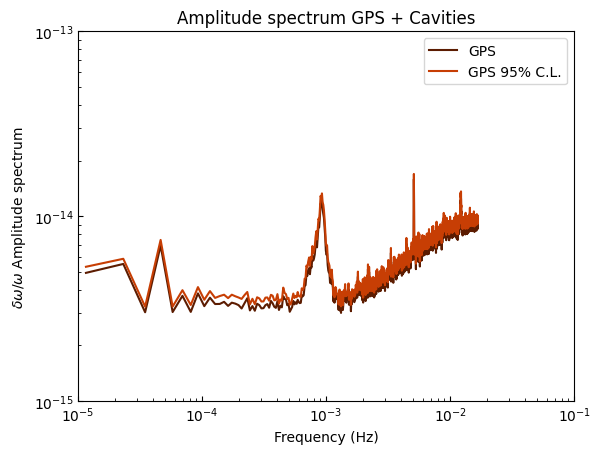

In [18]:
# don't continue line to zero frequency:
i0_gps = np.where(f_gps >= fmin)[0][0]
f_gps = f_gps[i0_gps:]
amp_gps = amp[i0_gps:]
gps_95 = cl95[i0_gps:]

plt.plot(f_gps, amp_gps, label="GPS", c="#5c1c01")
plt.plot(f_gps, gps_95, label="GPS 95% C.L.", c="#c73e04")

plt.title(f"Amplitude spectrum GPS + Cavities")
plt.legend()
plt.xlabel("Frequency (Hz)")
plt.ylabel("$\\delta\\omega/\\omega$ Amplitude spectrum")
plt.xlim(1e-5, 0.1)
plt.ylim(1e-15, 1e-13)
plt.xscale("log")
plt.yscale("log")
plt.tick_params(direction="in", which="both")
plt.show()

### Note

* Strong peaks at 12 and 6 hours: most likely linked to satellite orbit (period is 12 hours)
* This means we shouldn't use the data below 6 hours

------------
## Constraints:

In [19]:
def dm_freq(m):
    """Convert from DM mass (in eV) to frequency (in Hz)"""
    return 2.4e14 * m


def dm_mass(f):
    """Convert from frequency (in Hz) to DM mass (in eV)"""
    return f / dm_freq(1.0)


# DM amplitude factor phi_0 * kappa
def kappa_phi0(m):
    return 7.2e-31 / m


# c in km/s
c_kms = 3.0e5
# Stochasiticity correction:
f_stoch = 3.0
# (average) GPS RADIUS (time delay is from sat. to earth)
L_gps = 51000.0 / 2


# Factors for current analysis
gps_factor = kappa_phi0(1.0) * 2 * np.pi * dm_freq(1.0) * L_gps / c_kms


def dGPS(A):
    return f_stoch * A / gps_factor

### Constraints on coupling $d_{m_e}$

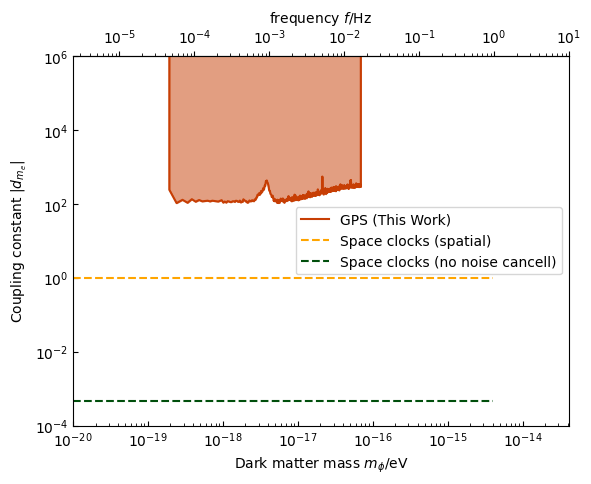

In [20]:
# Include constraints only below 6 hour period:
i0_gps_6h = np.where(f_gps >= 1.0 / (6 * 60 * 60))[0][0]
f_gps_6h = f_gps[i0_gps_6h:]
gps_95_6h = gps_95[i0_gps_6h:]

mm = np.concatenate(
    [[dm_mass(f_gps_6h[0])], dm_mass(f_gps_6h), [dm_mass(f_gps_6h[-1])]]
)
gps_constraint = np.concatenate([[1e7], dGPS(gps_95_6h), [1e7]])

# Ratios for projections
# Space clocks: spatial (extrap from cavities)
ratio1 = (750.0 / 51000) * (1.0e-18 / 7.0e-17) * (1.0 / np.sqrt(30))
# Space clocks: temporal (extrap from GPS, assume no noise cancelation)
ratio2 = (1.0e-18) / (2.3e-13)

fig, ax = plt.subplots()

# Our results:
plt.plot(mm, gps_constraint, label="GPS (This Work)", c="#c73e04")
plt.fill_between(mm, gps_constraint, 1e7, color="#c73e04", alpha=0.5)

plt.plot(
    [1e-20, 4e-15],
    [25557.28 * ratio1, 25557.28 * ratio1],
    "--",
    color="orange",
    label="Space clocks (spatial)",
)
plt.plot(
    [1e-20, 4e-15],
    [min(gps_constraint) * ratio2, min(gps_constraint) * ratio2],
    "--",
    color="#004f0c",
    label="Space clocks (no noise cancell)",
)

plt.xlim(1e-20, dm_mass(10.0))
plt.ylim(1e-4, 1e6)
plt.xscale("log")
plt.yscale("log")
plt.ylabel("")
plt.xlabel("Dark matter mass $m_\\phi/{\\rm eV}$")
plt.ylabel("Coupling constant $|d_{m_e}|$")
plt.legend()
plt.tick_params(direction="in", which="both")

secax = ax.secondary_xaxis("top", functions=(dm_freq, dm_mass))
secax.set_xlabel("frequency $f/{\\rm Hz}$")

plt.show()